In [695]:
import warnings
warnings.filterwarnings("ignore")

In [696]:
sym1 = "Mastercard"
sym2 = "Visa"

In [697]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import statsmodels.api as sm
from arch.unitroot import ADF
import yfinance as yf
import time

# H0: not stationary
# pval > 0.05, cannot reject H0 --> not stationary
# otherwise, stationary
def adfTest(series):
    adfT = ADF(series)
    if adfT.pvalue > 0.05:
        return False, adfT.pvalue
    return True, adfT.pvalue

def visualize(data, symbols, y_axis, title):
    plt.figure(figsize=(15, 7))
    for syl in symbols:
        data[syl].plot(label=syl)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(y_axis)
    plt.title(title)
    plt.savefig(f"{title}.png", dpi=300, bbox_inches="tight") 
    plt.show()
    print("Successfully Plotted")

def spread(X, Y):
    sp = Y - X
    is_stationary, pval = adfTest(sp)
    print(sp)
    if not is_stationary:
        print(f"Spread is not stationary. P value of ADF test is {pval}")
    else:
        print(f'''
            Spread is stationary
            P value of ADF test: {pval}
            ''')
    return sp
    
def cointegration(X, Y):
    # add_constant: intercept
    results = sm.OLS(Y, sm.add_constant(X)).fit()
    resid = results.resid
    intercept, beta = results.params
    is_stationary, pval = adfTest(resid)
    if not is_stationary:
        print(f"Not cointegrated. P value of ADF test is {pval}")
        return None
    else:
        print(f'''
        Cointegrated
        P value of ADF test: {pval}
        Intercept: {intercept}
        Beta: {beta}''')
        return intercept, beta


def ols_real_time(data, symbols):
    """
    Perform OLS in real-time using all data up to each timestamp.
    For each timestamp, use all prior data (up to i) to compute OLS parameters.
    """
    slopes, intercepts = [], []  

    for i in range(2, len(data)):
        # Use all data up to the current index i
        X = sm.add_constant(data[symbols[0]].iloc[:i])  
        Y = data[symbols[1]].iloc[:i] 

        results = sm.OLS(Y, X).fit()
        intercepts.append(results.params[0]) 
        slopes.append(results.params[1])  
    
    intercept_series = pd.Series(intercepts, index=data.index[2:])
    slope_series = pd.Series(slopes, index=data.index[2:])
    
    return intercept_series, slope_series

def kalman_filter_real_time(data, symbols):
    """
    Perform Kalman filter in real-time with a sliding window.
    For each timestamp, use only past data (up to that point).
    """
    slopes, intercepts = [], []  
    trans_cov = 1e-5 / (1 - 1e-5) * np.eye(2)  # transition covariance matrix

    # At least two starting points to create a 2var-2equation set (2 states!)
    for i in range(2, len(data)):  
        # Use data up to the current point
        obs_sym_0 = data[symbols[0]].iloc[:i] 
        obs_sym_1 = data[symbols[1]].iloc[:i]
        obs_mat = sm.add_constant(obs_sym_0.values, prepend=False)[:, np.newaxis]

        kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,  # 1D observation (price), 2D state (slope, intercept)
                          initial_state_mean=np.ones(2),  # Initial state mean (slope, intercept)
                          initial_state_covariance=np.eye(2),  # Initial covariance
                          transition_matrices=np.eye(2),  # Identity for independent evolution of intercept & slope
                          observation_matrices=obs_mat,  # Observation matrix
                          observation_covariance=0.5,  # Assume some noise in observations
                          transition_covariance=trans_cov)  # Transition covariance

        state_means, state_covs = kf.filter(obs_sym_1.values)  # Apply Kalman filter
        
        # Extract the most recent estimates for slope and intercept
        slope = state_means[-1, 0]  
        intercept = state_means[-1, 1] 
        
        slopes.append(slope)
        intercepts.append(intercept)

    intercept_series = pd.Series(intercepts, index=data.index[2:])
    slope_series = pd.Series(slopes, index=data.index[2:])
    
    return intercept_series, slope_series

In [698]:
def plot_rolling_statistics(ts, method, window=50):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    
    plt.figure(figsize=(12,6))
    plt.plot(ts, color='grey', label='Original Time Series')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='blue', label='Rolling Std Dev')
    plt.legend()
    plt.title(f'Rolling Mean & Standard Deviation: {method}')
    plt.show()

In [783]:
import matplotlib.pyplot as plt
import pandas as pd

threshold = 1.2
thre2 = 0.3

def trading_bot_with_spread(data, method):
    """
    Mean-reversion trading Bot with Buy, Sell, and Close Signals based on the spread.
    
    """
    spread_column = data.columns[0]  
    df = data.copy()

    df['mean'] = df[spread_column].expanding().mean().shift(1)
    df['std'] = df[spread_column].expanding().std().shift(1)
    # df['mean'] = df[spread_column].rolling(window=20).mean().shift(1)
    # df['std'] = df[spread_column].rolling(window=20).std().shift(1)
    df['upper'] = df['mean'] + threshold * df['std']  # Upper threshold (overbought)
    df['lower'] = df['mean'] - threshold * df['std']  # Lower threshold (oversold)
    df['retH'] = df['mean'] + thre2 * df['std']  # Upper reversion 
    df['retL'] = df['mean'] - thre2 * df['std']  # Lower reversion 
    

    df['buy_signal'] = (df[spread_column] < df['lower']) & (df[spread_column].shift(1) >= df['lower'].shift(1))
    df['sell_signal'] = (df[spread_column] > df['upper']) & (df[spread_column].shift(1) <= df['upper'].shift(1))
    df['close_position_signal'] = ((df[spread_column] > df['retL']) & (df[spread_column].shift(1) <= df['retL'].shift(1))) | \
                                  ((df[spread_column] < df['retH']) & (df[spread_column].shift(1) >= df['retH'].shift(1)))
    position = 0  # 1 for long, -1 for short, 0 for no position
    entry_price = 0
    cash = 0  # Cash balance
    traced_cash = []  # Track cash balance
    asset_value = []  # Track total asset value (cash + open position value)
    trade_log = [] 

    for i in range(len(df)):
        # Buy signal: Enter long position
        if df['buy_signal'].iloc[i] and position == 0:
            position = 1
            entry_price = df[spread_column].iloc[i]
            cash -= entry_price  # Subtract entry price from cash balance
            trade_log.append(f"Buy at {entry_price}")
        
        # Sell signal: Enter short position
        elif df['sell_signal'].iloc[i] and position == 0:
            position = -1
            entry_price = df[spread_column].iloc[i]
            cash += entry_price  # Add entry price to cash balance 
            trade_log.append(f"Sell at {entry_price}")
        
        # Close position signal: Exit position
        elif df['close_position_signal'].iloc[i] and position != 0:
            exit_price = df[spread_column].iloc[i]
            # profit = (exit_price - entry_price) * position
            # cash += profit  
            profit = (exit_price - entry_price) * position
            cash += exit_price * position
            trade_log.append(f"Close position at {exit_price}, Profit: {profit}")
            position = 0  

        # Calculate asset value
        if position != 0:
            # current_position_value = (df[spread_column].iloc[i] - entry_price) * position
            current_position_value = df[spread_column].iloc[i] * position
            asset_value.append(cash + current_position_value)  # Total value = cash + unrealized position value
        else:
            asset_value.append(cash)  # No open position, asset value is just cash

        traced_cash.append(cash)
        trade_log.append(f"Cash: {cash}, Asset: {asset_value[len(asset_value)-1]}")

    # Handle final position if still open at the end of the loop
    # if position != 0:
    #     final_exit_price = df[spread_column].iloc[-1]
    #     final_profit = (final_exit_price - entry_price) * position
    #     cash += final_profit
    #     trade_log.append(f"Final close at {final_exit_price}, Profit: {final_profit}")
    #     asset_value.append(cash)  

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[spread_column], label='Spread', color='grey')
    plt.plot(df.index, df['mean'], label='Mean', color='red', linestyle='--')
    plt.plot(df.index, df['upper'], label='Upper Threshold', color='blue', linestyle='--')
    plt.plot(df.index, df['lower'], label='Lower Threshold', color='blue', linestyle='--')
    plt.plot(df.index, df['retH'], label='Rev Upper Thresh', color='orange', linestyle='--')
    plt.plot(df.index, df['retL'], label='Rev Lower Thresh', color='orange', linestyle='--')

    plt.plot(df.index[df['buy_signal']], df[spread_column][df['buy_signal']], 'g^', label='Buy Signal')
    plt.plot(df.index[df['sell_signal']], df[spread_column][df['sell_signal']], 'cv', label='Sell Signal')
    plt.plot(df.index[df['close_position_signal']], df[spread_column][df['close_position_signal']], 'ro', label='Close Position Signal')

    plt.xlabel('Time')
    plt.ylabel('Spread Value')
    plt.title(f'Mean-Reversion Trading Signals: {method}')
    plt.legend()
    plt.savefig(f"Mean-Reversion_Trading_Signals: {method}.png", dpi=300, bbox_inches="tight") 
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, asset_value[:len(df)], label='Asset Value', color='orange')
    plt.plot(df.index, traced_cash[:len(df)], label='Cash', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Asset/Cash Over Time: {method}')
    plt.legend()
    plt.savefig(f"Asset_Cash_Over_Time.png", dpi=300, bbox_inches="tight") 
    plt.show()

    for log in trade_log:
        print(log)

    print(f"Final Profit: {cash}")
    return cash, df, traced_cash, asset_value

# Data Preprocessing

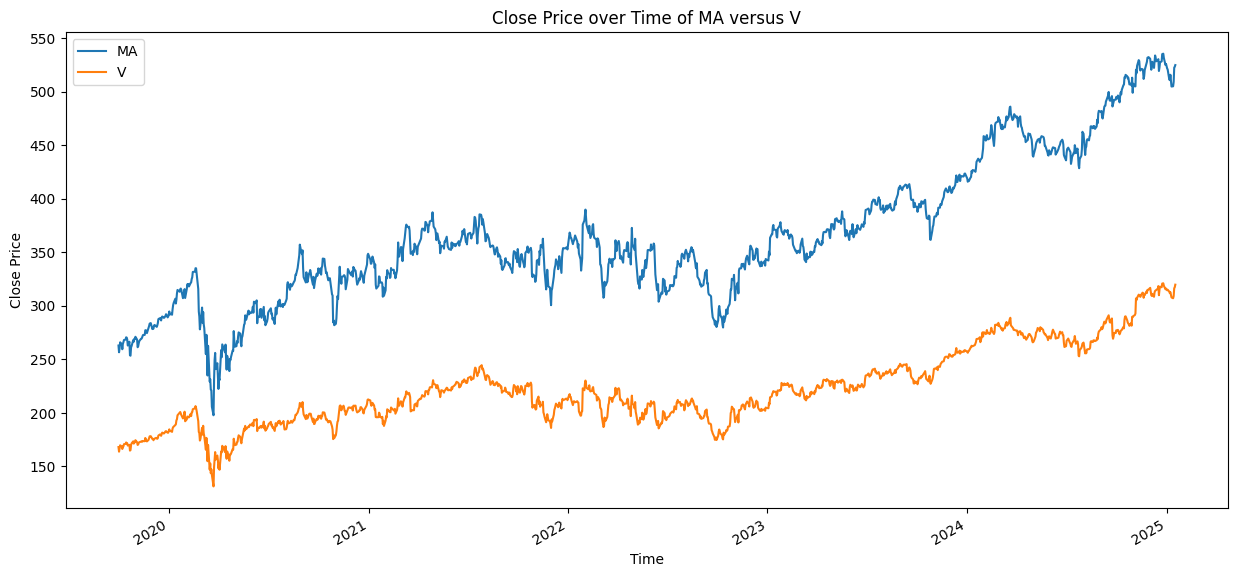

Successfully Plotted


In [701]:
MA = yf.Ticker("MA")
V = yf.Ticker("V")
hist = pd.DataFrame()
start_date = "2019-10-01"
end_date = "2025-01-20"
hist['MA'] = pd.DataFrame(MA.history(start=start_date, end=end_date)['Close'])
hist['V'] = pd.DataFrame(V.history(start=start_date, end=end_date)['Close'])
hist.dropna(axis = 0, inplace = True)
syms = ['MA', 'V']
visualize(hist, syms, "Close Price", "Close Price over Time of MA versus V")


In [702]:
pd.isna(hist).sum()

MA    0
V     0
dtype: int64

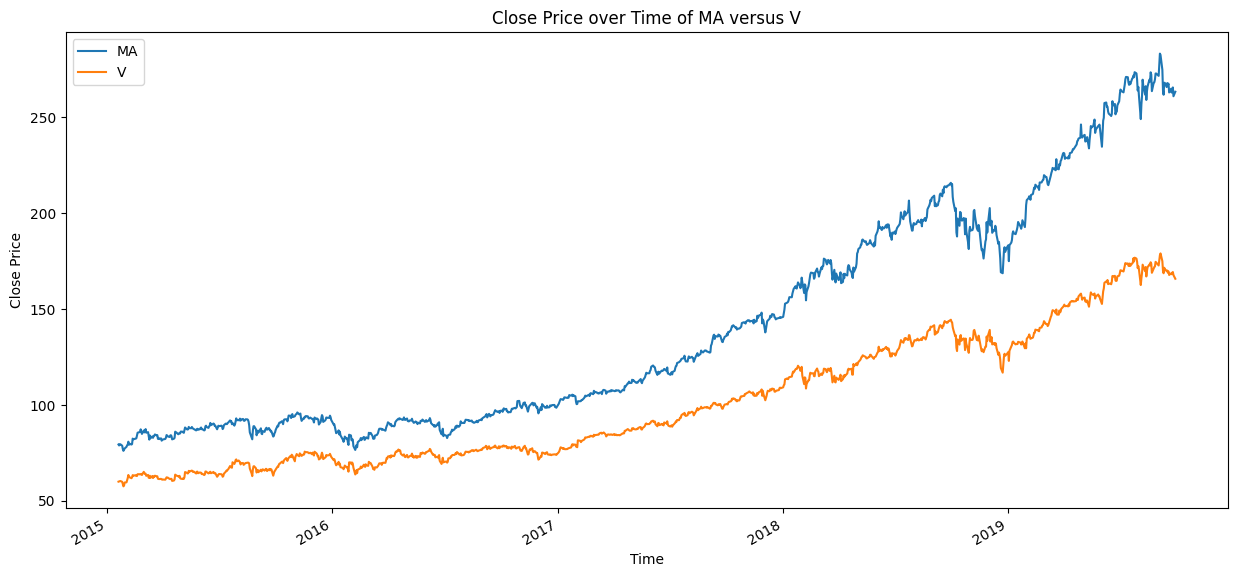

Successfully Plotted


In [703]:
MA = yf.Ticker("MA")
V = yf.Ticker("V")
prior = pd.DataFrame()
start_date = "2015-01-20"
end_date = "2019-10-01"
prior['MA'] = pd.DataFrame(MA.history(start=start_date, end=end_date)['Close'])
prior['V'] = pd.DataFrame(V.history(start=start_date, end=end_date)['Close'])
prior.dropna(axis = 0, inplace = True)
syms = ['MA', 'V']
visualize(prior, syms, "Close Price", "Close Price over Time of MA versus V")

In [704]:
pd.isna(prior).sum()

MA    0
V     0
dtype: int64

In [705]:
bsl_intercept, bsl_beta = cointegration(prior['MA'], prior['V'])


        Cointegrated
        P value of ADF test: 0.034905973164835784
        Intercept: 19.89043413985408
        Beta: 0.5743298425848162


In [706]:
bsl_spread = hist['V'] - bsl_intercept - bsl_beta * hist['MA']

### Close prices of two assets are not stationary

In [708]:
adfTest(hist['MA'])

(False, 0.8233264301911194)

In [709]:
adfTest(hist['V'])

(False, 0.8854925522186095)

Date
2019-10-01 00:00:00-04:00    -94.801865
2019-10-02 00:00:00-04:00    -92.835007
2019-10-03 00:00:00-04:00    -93.600296
2019-10-04 00:00:00-04:00    -96.199097
2019-10-07 00:00:00-04:00    -95.426361
                                ...    
2025-01-13 00:00:00-05:00   -197.989990
2025-01-14 00:00:00-05:00   -199.929993
2025-01-15 00:00:00-05:00   -206.069977
2025-01-16 00:00:00-05:00   -205.890015
2025-01-17 00:00:00-05:00   -205.080017
Name: None, Length: 1333, dtype: float64
Spread is not stationary. P value of ADF test is 0.5484182322955737


<Axes: xlabel='Date'>

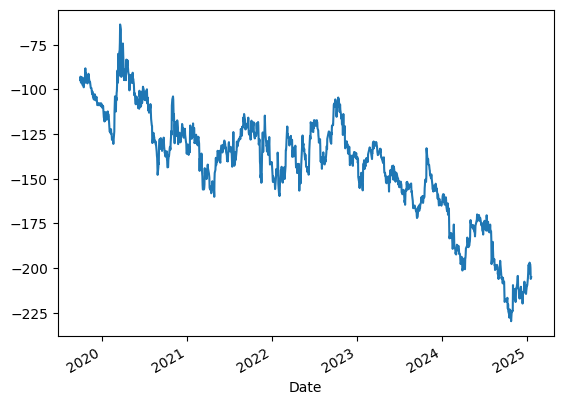

In [710]:
sp = spread(hist['MA'], hist['V'])
sp.plot()

In [711]:
cointegration(hist['MA'], hist['V'])


        Cointegrated
        P value of ADF test: 0.0001012391160363738
        Intercept: 27.147965025093193
        Beta: 0.5340093580226759


(27.147965025093193, 0.5340093580226759)

# Extract intercepts and slopes using both OLS and Kalman Filter

In [713]:
# Extract intercepts & slopes over time by using OLS fitting on all price history prior to each timestamp
intercept_ols, slope_ols = ols_real_time(hist, syms)

In [714]:
# Extract intercepts & slopes over time by applying the Kalman Filter on all price history prior to each timestamp
start_time = time.time() 
intercept_kf, slope_kf = kalman_filter_real_time(hist, syms)
end_time = time.time() 
elapsed_time = end_time - start_time

print(f"Runtime of KF: {elapsed_time:.4f} seconds") 

Runtime of KF: 144.1781 seconds


In [715]:
kf_spread = hist['V']- hist['MA'] * slope_kf - intercept_kf
coin_spread = hist['V']- hist['MA'] * slope_ols - intercept_ols

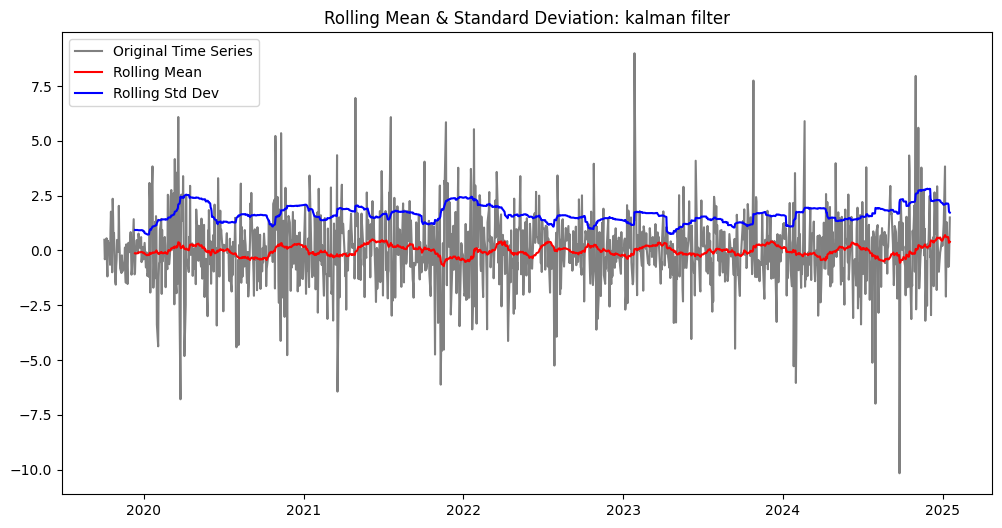

In [716]:
plot_rolling_statistics(kf_spread, "kalman filter")

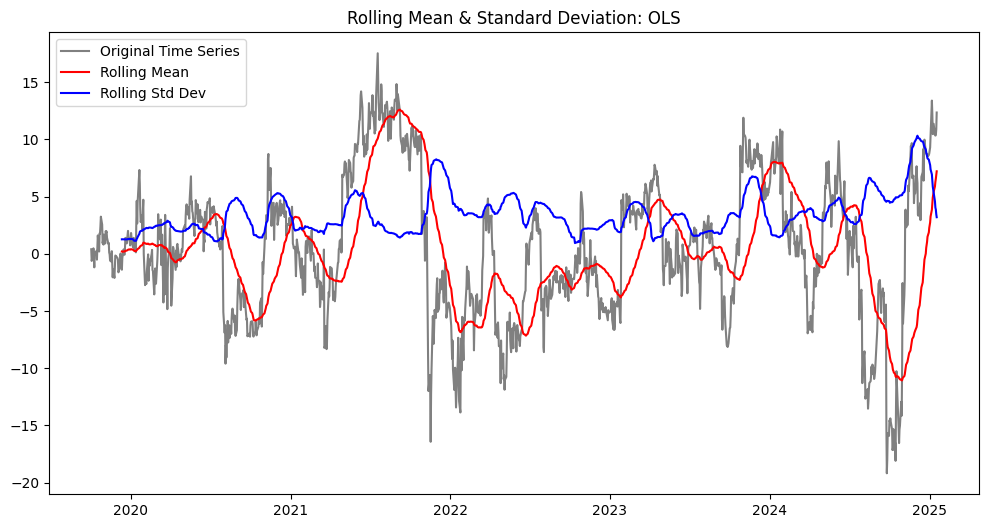

In [717]:
plot_rolling_statistics(coin_spread, "OLS")

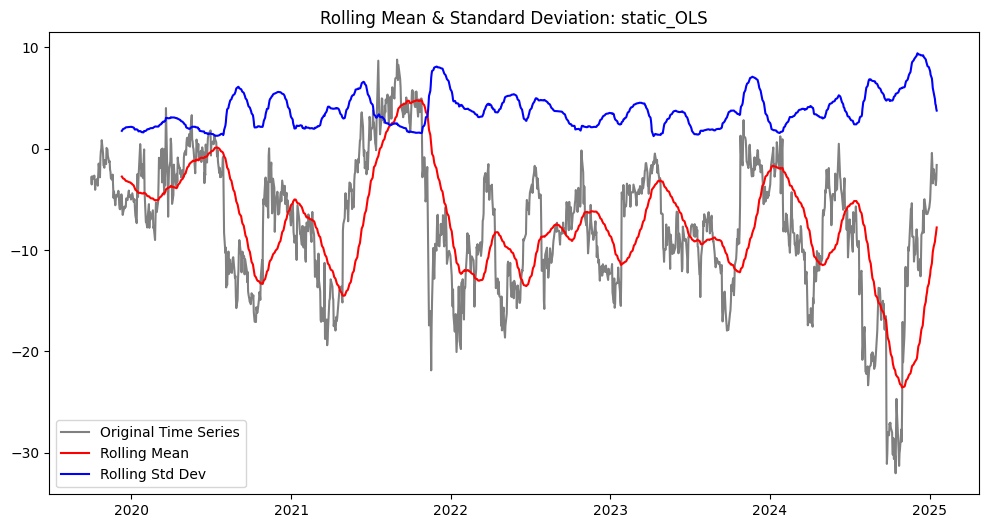

In [718]:
plot_rolling_statistics(bsl_spread, "static_OLS")

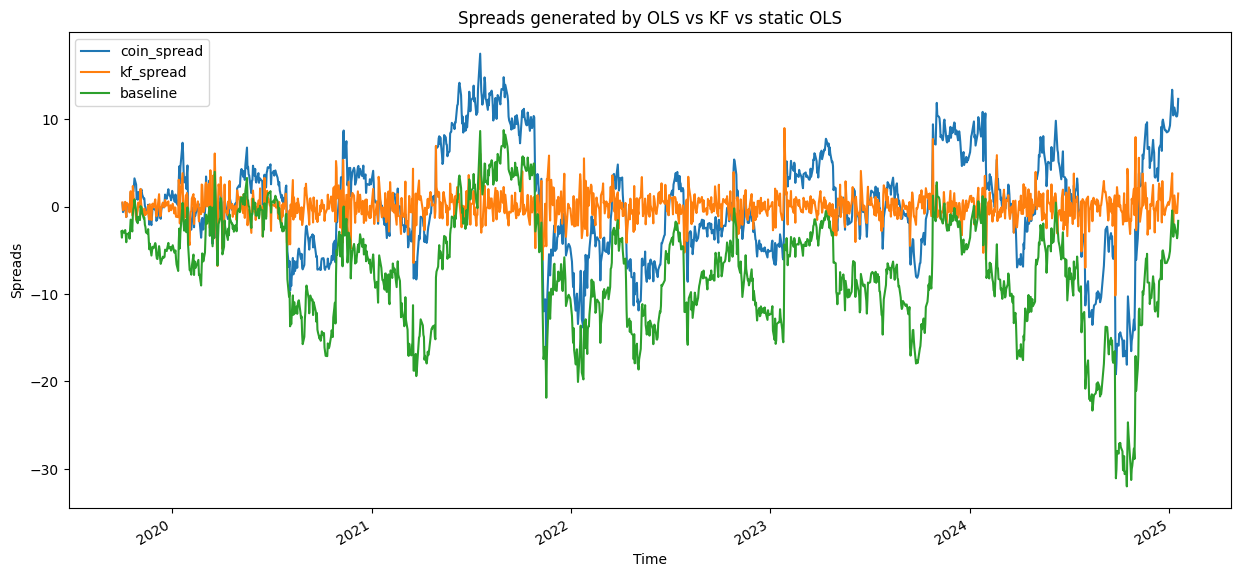

Successfully Plotted


In [719]:
res = pd.DataFrame()
res['coin_spread'], res['kf_spread'] = coin_spread, kf_spread
res['baseline'] = bsl_spread

spread_syms = ["coin_spread", "kf_spread"]
syms = ['coin_spread', 'kf_spread', 'baseline']
visualize(res, syms, 'Spreads', "Spreads generated by OLS vs KF vs static OLS")

In [720]:
res = res.dropna()
res.to_csv("cached_spread_results.csv")

# Apply the mean-reversion trading bot on spreads extracted using both OLS and Kalman Filter

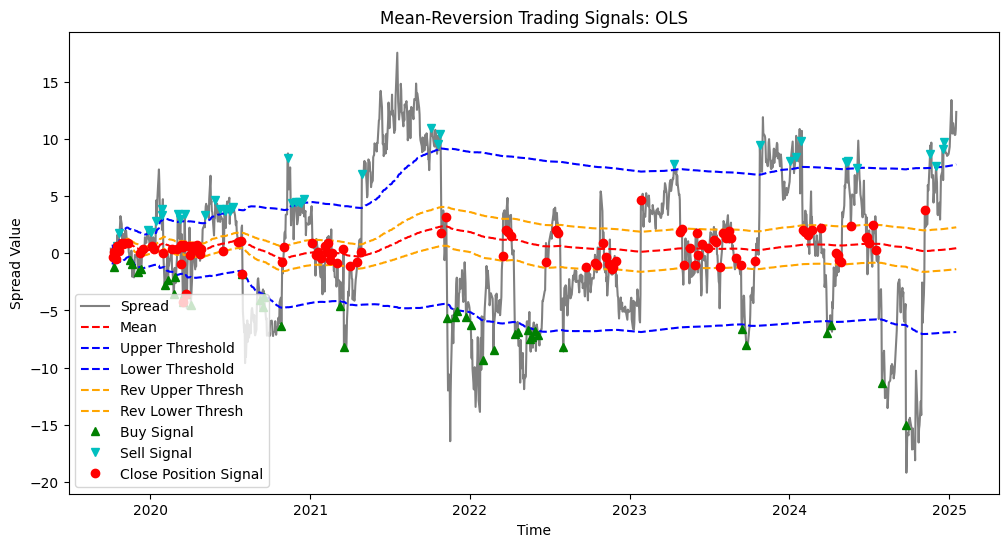

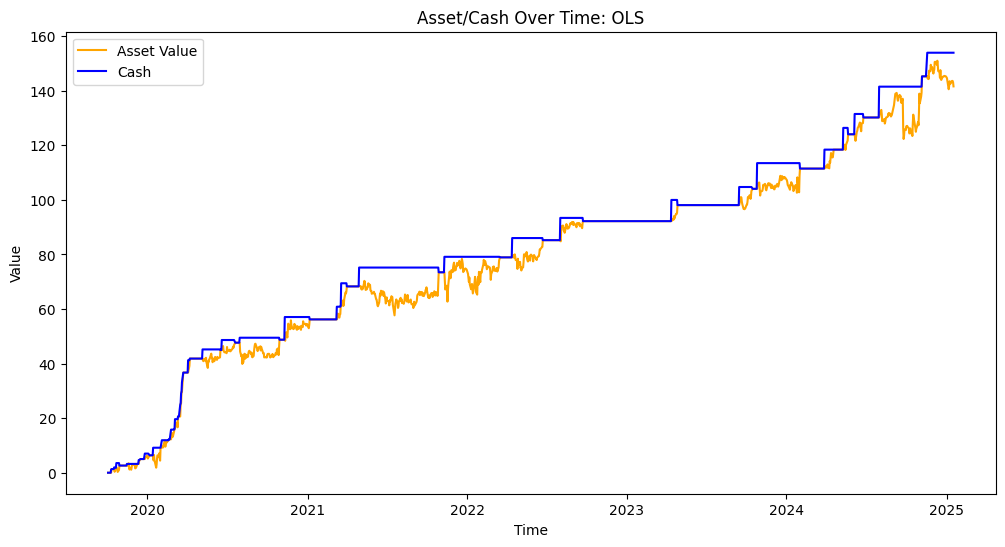

Cash: 0, Asset: 0
Cash: 0, Asset: 0
Cash: 0, Asset: 0
Cash: 0, Asset: 0
Cash: 0, Asset: 0
Buy at -1.1875520421532713
Cash: 1.1875520421532713, Asset: 0.0
Close position at 0.14683324608122916, Profit: 1.3343852882345004
Cash: 1.3343852882345004, Asset: 1.3343852882345004
Cash: 1.3343852882345004, Asset: 1.3343852882345004
Cash: 1.3343852882345004, Asset: 1.3343852882345004
Cash: 1.3343852882345004, Asset: 1.3343852882345004
Sell at 0.6171092290856564
Cash: 1.9514945173201568, Asset: 1.3343852882345004
Cash: 1.9514945173201568, Asset: 0.35024265498122986
Close position at 0.19572165785226048, Profit: 0.4213875712333959
Cash: 1.7557728594678963, Asset: 1.7557728594678963
Sell at 1.781742273999015
Cash: 3.5375151334669113, Asset: 1.7557728594678963
Cash: 3.5375151334669113, Asset: 1.7899498850102304
Cash: 3.5375151334669113, Asset: 1.139505812024737
Cash: 3.5375151334669113, Asset: 0.2973215423071309
Cash: 3.5375151334669113, Asset: 0.9999827901358884
Close position at 0.9165618683070846,

In [785]:
df_coin = pd.DataFrame(res["coin_spread"])
coin_fprofit, coin_df_with_signals, coin_cash, coin_asset = trading_bot_with_spread(df_coin, "OLS")

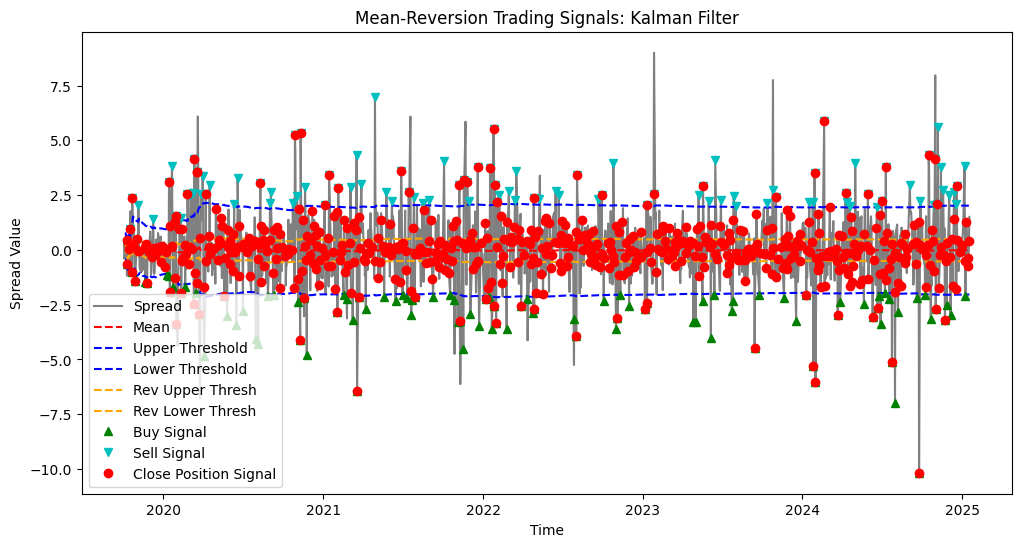

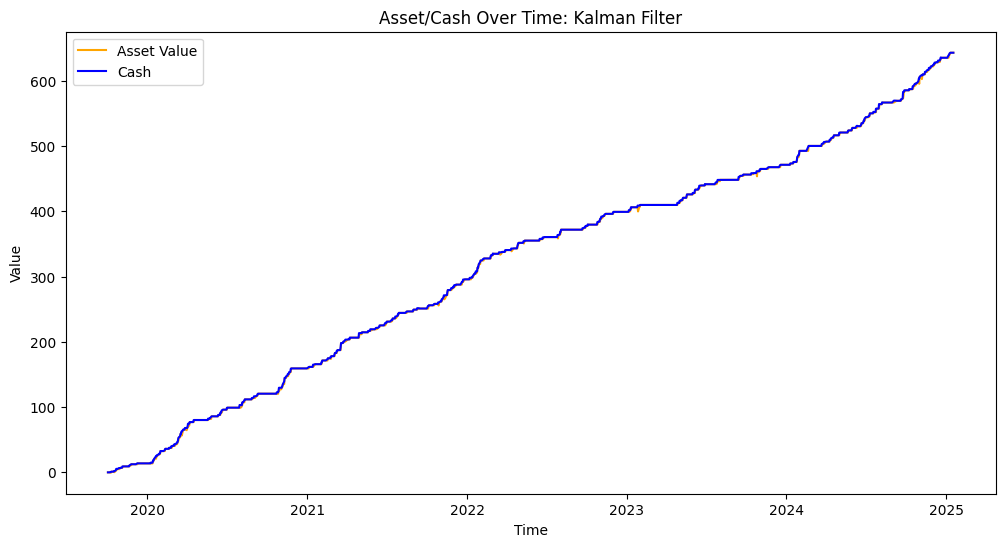

Cash: 0, Asset: 0
Cash: 0, Asset: 0
Cash: 0, Asset: 0
Cash: 0, Asset: 0
Buy at -0.6371010643008879
Cash: 0.6371010643008879, Asset: 0.0
Cash: 0.6371010643008879, Asset: -0.5486829678383716
Close position at 0.44282156081199164, Profit: 1.0799226251128795
Cash: 1.0799226251128795, Asset: 1.0799226251128795
Cash: 1.0799226251128795, Asset: 1.0799226251128795
Cash: 1.0799226251128795, Asset: 1.0799226251128795
Cash: 1.0799226251128795, Asset: 1.0799226251128795
Sell at 0.9379263959615094
Cash: 2.017849021074389, Asset: 1.0799226251128795
Cash: 2.017849021074389, Asset: 0.24734467674338134
Close position at -0.9965349004785842, Profit: 1.9344612964400936
Cash: 3.014383921552973, Asset: 3.014383921552973
Sell at 2.35977111390049
Cash: 5.374155035453463, Asset: 3.014383921552973
Cash: 5.374155035453463, Asset: 3.8636428866370105
Close position at 0.22852899949064298, Profit: 2.1312421144098472
Cash: 5.14562603596282, Asset: 5.14562603596282
Cash: 5.14562603596282, Asset: 5.14562603596282
Buy

In [786]:
df_kf = pd.DataFrame(res["kf_spread"])
kf_fprofit, kf_df_with_signals, kf_cash, kf_asset = trading_bot_with_spread(df_kf, "Kalman Filter")

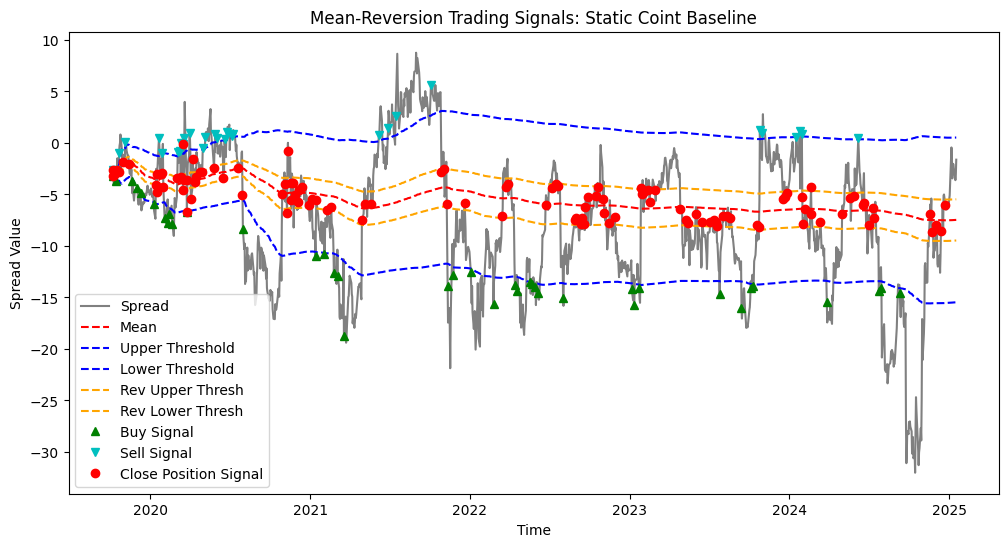

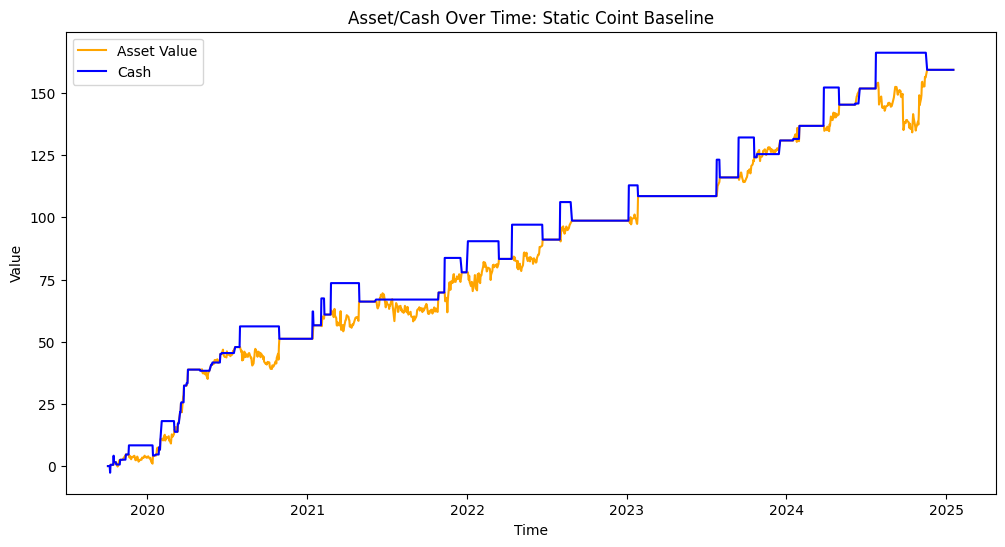

Cash: 0, Asset: 0
Cash: 0, Asset: 0
Cash: 0, Asset: 0
Sell at -2.6695542879768936
Cash: -2.6695542879768936, Asset: 0.0
Close position at -3.181999756914479, Profit: 0.5124454689375852
Cash: 0.5124454689375852, Asset: 0.5124454689375852
Cash: 0.5124454689375852, Asset: 0.5124454689375852
Cash: 0.5124454689375852, Asset: 0.5124454689375852
Cash: 0.5124454689375852, Asset: 0.5124454689375852
Cash: 0.5124454689375852, Asset: 0.5124454689375852
Buy at -3.6633817026640827
Cash: 4.175827171601668, Asset: 0.5124454689375852
Close position at -2.6143606295114807, Profit: 1.049021073152602
Cash: 1.5614665420901872, Asset: 1.5614665420901872
Cash: 1.5614665420901872, Asset: 1.5614665420901872
Cash: 1.5614665420901872, Asset: 1.5614665420901872
Sell at -0.9327515986203423
Cash: 0.6287149434698449, Asset: 1.5614665420901872
Cash: 0.6287149434698449, Asset: 0.8895527450395662
Cash: 0.6287149434698449, Asset: 0.630943753719805
Cash: 0.6287149434698449, Asset: -0.194676656506374
Cash: 0.6287149434698

In [787]:
df_base = pd.DataFrame(res['baseline'])
base_fprofit, base_df_with_signals, base_cash, base_asset = trading_bot_with_spread(df_base, "Static Coint Baseline")

# Visualization of Cash & Asset over time

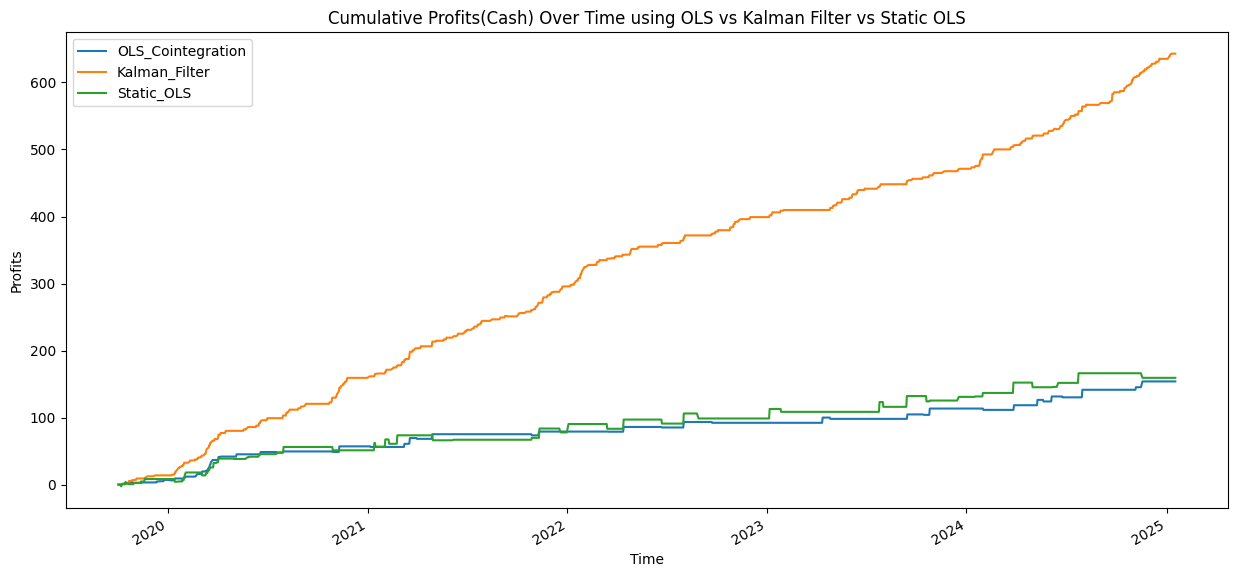

Successfully Plotted


In [792]:
results_cash = pd.DataFrame({
    "OLS_Cointegration": coin_cash,
    "Kalman_Filter": kf_cash,
    "Static_OLS": base_cash,
})
results_cash.index = df_coin.index
fields = results_cash.columns
visualize(results_cash, fields, "Profits", "Cumulative Profits(Cash) Over Time using OLS vs Kalman Filter vs Static OLS")

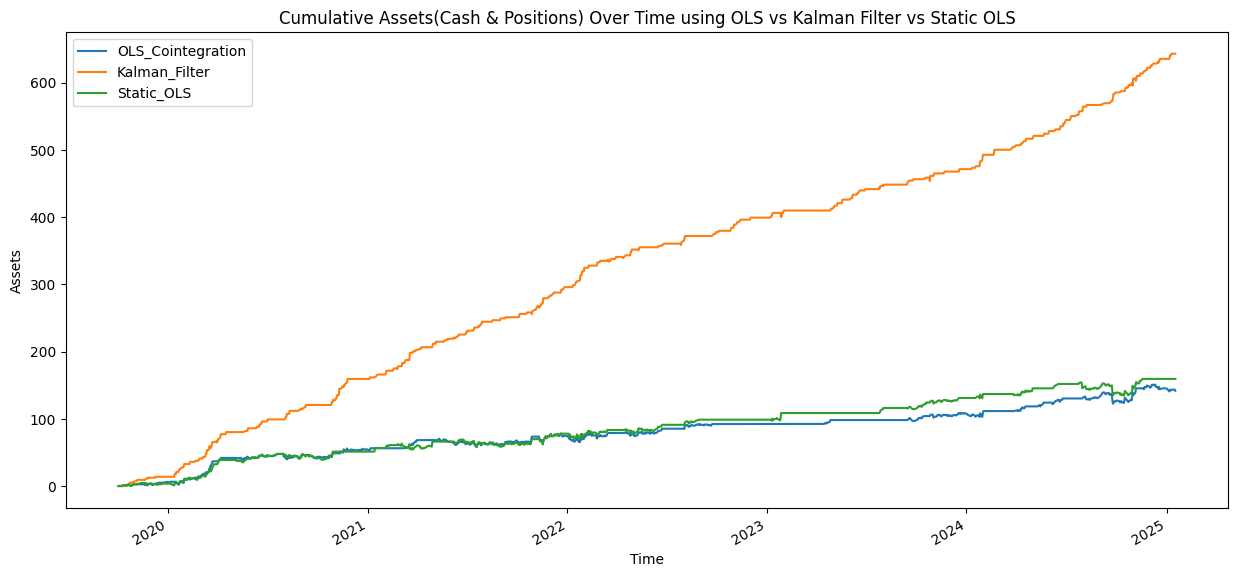

Successfully Plotted


In [793]:
# length = min(len(coin_asset), len(kf_asset), len(base_asset))
# coin_asset = coin_asset[:length]
# kf_asset = kf_asset[:length]
# base_asset = base_asset[:length]

results_asset = pd.DataFrame({
    "OLS_Cointegration": coin_asset,
    "Kalman_Filter": kf_asset,
    "Static_OLS": base_asset,
})
results_asset.index = df_coin.index
fields = results_asset.columns
visualize(results_asset, fields, "Assets", "Cumulative Assets(Cash & Positions) Over Time using OLS vs Kalman Filter vs Static OLS")

# Evaluation Metrics (total profits & max drawdown)

In [729]:
pkf_coin = (kf_fprofit - coin_fprofit) / coin_fprofit
pkf_base = (kf_fprofit - base_fprofit) / base_fprofit
pcoin_base = (coin_fprofit - base_fprofit) / base_fprofit
print(f"OLS Pair Trading profit: {coin_fprofit}")
print(f"Kalman Filter Pair Trading profit: {kf_fprofit}")
print(f"Static OLS Pair Trading profit: {base_fprofit}")
print(f"Kalman Filter Pair Trading increases final profit by {pkf_coin*100}% compared to the OLS")
print(f"Kalman Filter Pair Trading increases final profit by {pkf_base*100}% compared to the static OLS (base)")
print(f"OLS Pair Trading increases final profit by {pcoin_base*100}% compared to the static OLS (base)")

OLS Pair Trading profit: 119.50321613527743
Kalman Filter Pair Trading profit: 360.5770985599697
Static OLS Pair Trading profit: 99.26583588843472
Kalman Filter Pair Trading increases final profit by 201.7300372500411% compared to the OLS
Kalman Filter Pair Trading increases final profit by 263.2439049475429% compared to the static OLS (base)
OLS Pair Trading increases final profit by 20.387054685750673% compared to the static OLS (base)


In [730]:
def max_drawdown(series):
    series = np.array(series)
    peak = np.maximum.accumulate(series)
    drawdown = (series - peak) / peak
    drawdown[np.isnan(drawdown)] = 0
    max_dd = np.min(drawdown)
    
    return max_dd

In [731]:
kf_dd_cash = max_drawdown(kf_cash)
coin_dd_cash = max_drawdown(coin_cash)
base_dd_cash = max_drawdown(base_cash)
eff_kf_coin = (kf_dd_cash - coin_dd_cash) / coin_dd_cash * (-1)
eff_kf_base = (kf_dd_cash - base_dd_cash) / base_dd_cash * (-1)
eff_coin_base = (coin_dd_cash - base_dd_cash) / base_dd_cash * (-1)
print("Cash Results")
print(f"Max Drawdown of KF Pair Trading: {kf_dd_cash*100}%")
print(f"Max Drawdown of Sliding OLS Pair Trading: {coin_dd_cash*100}%")
print(f"Max Drawdown of Static OLS Pair Trading: {base_dd_cash*100}%")
print(f"KF Pair Trading decreases max drawdown by {eff_kf_coin*100}% compared to the Sliding OLS")
print(f"KF Pair Trading decreases max drawdown by {eff_kf_base*100}% compared to the Static OLS")
print(f"Sliding OLS Pair Trading decreases max drawdown by {eff_coin_base*100}% compared to the Static OLS")

Cash Results
Max Drawdown of KF Pair Trading: -3.3829004923737043%
Max Drawdown of Sliding OLS Pair Trading: -20.27048298641849%
Max Drawdown of Static OLS Pair Trading: -144.9441073211213%
KF Pair Trading decreases max drawdown by 83.31119936984088% compared to the Sliding OLS
KF Pair Trading decreases max drawdown by 97.66606552353387% compared to the Static OLS
Sliding OLS Pair Trading decreases max drawdown by 86.01496579539479% compared to the Static OLS


In [732]:
kf_dd_asset = max_drawdown(kf_asset)
coin_dd_asset = max_drawdown(coin_asset)
base_dd_asset = max_drawdown(base_asset)
eff_kf_coin = (kf_dd_asset - coin_dd_asset) / coin_dd_asset * (-1)
eff_kf_base = (kf_dd_asset - base_dd_asset) / base_dd_asset * (-1)
eff_coin_base = (coin_dd_asset - base_dd_asset) / base_dd_asset * (-1)
print("Asset Results")
print(f"Max Drawdown of KF Pair Trading: {kf_dd_asset*100}%")
print(f"Max Drawdown of Sliding OLS Pair Trading: {coin_dd_asset*100}%")
print(f"Max Drawdown of Static OLS Pair Trading: {base_dd_asset*100}%")
print(f"KF Pair Trading decreases max drawdown by {eff_kf_coin*100}% compared to the Sliding OLS")
print(f"KF Pair Trading decreases max drawdown by {eff_kf_base*100}% compared to the Static OLS")
print(f"Sliding OLS Pair Trading decreases max drawdown by {eff_coin_base*100}% compared to the Static OLS")

Asset Results
Max Drawdown of KF Pair Trading: -5.9922723326981915%
Max Drawdown of Sliding OLS Pair Trading: -80.29165005355242%
Max Drawdown of Static OLS Pair Trading: -inf%
KF Pair Trading decreases max drawdown by 92.53686737201004% compared to the Sliding OLS
KF Pair Trading decreases max drawdown by nan% compared to the Static OLS
Sliding OLS Pair Trading decreases max drawdown by nan% compared to the Static OLS
